In [4]:
import random
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import math
import tqdm

In [18]:
p_1=50
p_2=50
n=150
r_J_or=5
r_1_or=5
r_2_or=5
r_prop=1.0
W_J_lis=[100,10,0.1,0.1,0.01]
W_1_lis=[100,10,0.1,0.1,0.01]
W_2_lis=[100,10,0.1,0.1,0.01]
X1_erro=0
X2_erro=0
y_erro=0

#sJIVEとproposed共通の条件
k = 5
kf = KFold(n_splits=k)

times=100
threshold=10.0

times_tes=100
threshold_tes=10.0 


In [19]:
#データの生成
X_1_al,X_2_al,y_al=function.gene_data_2(p_1,p_2,n,r_J_or,r_1_or,r_2_or,r_prop,W_J_lis,W_1_lis,W_2_lis,X1_erro,X2_erro,y_erro)
X_1_original=X_1_al[:,:100]
X_2_original=X_2_al[:,:100]
y_original=y_al[:,:100]

X_1_test=X_1_al[:,100:150]
X_2_test=X_2_al[:,100:150]
y_test=y_al[:,100:150]

df_tra=np.row_stack((X_1_original,X_2_original,y_original))
df_tes=np.row_stack((X_1_test,X_2_test,y_test))

In [20]:
eta=0.5
r_J=10
r_1=10
r_2=10
gamma_1=10
gamma_21=10
gamma_22=10

In [22]:
X_1_or=X_1_original
X_2_or=X_2_original
y_or=y_original

In [30]:
number_best=0
times=times
erro_lis=[]
erro_best=1000.0
threshold=threshold
p_1=X_1_or.shape[0]
p_2=X_2_or.shape[0]
n=X_1_or.shape[1]
X_1=math.sqrt(eta)*X_1_or
X_2=math.sqrt(eta)*X_2_or
y=math.sqrt(1-eta)*y_or
#初期値を入れる
U_1=U_1_best=math.sqrt(eta)*np.random.uniform(low=-0.1, high=0.1, size=(p_1,r_J))
U_2=U_2_best=math.sqrt(eta)*np.random.uniform(low=-0.1, high=0.1, size=(p_2,r_J))
W_1=W_1_best=math.sqrt(eta)*np.random.uniform(low=-0.1, high=0.1, size=(p_1,r_1))
W_2=W_2_best=math.sqrt(eta)*np.random.uniform(low=-0.1, high=0.1, size=(p_2,r_2))
theta_1=theta_1_best=math.sqrt(1-eta)*np.random.uniform(low=-0.1, high=0.1, size=int(r_J))
theta_21=theta_21_best=math.sqrt(1-eta)*np.random.uniform(low=-0.1, high=0.1, size=int(r_1))
theta_22=theta_22_best=math.sqrt(1-eta)*np.random.uniform(low=-0.1, high=0.1, size=int(r_2))
S_J=S_J_best=np.random.uniform(low=-0.1, high=0.1, size=(r_J,n))
S_1=S_1_best=np.random.uniform(low=-0.1, high=0.1, size=(r_1,n))
S_2=S_2_best=np.random.uniform(low=-0.1, high=0.1, size=(r_2,n))
hat_X_y_best=np.random.uniform(low=-0.1, high=0.1, size=(p_1+p_2+1,n))

zeros_1=np.zeros((p_2, r_1))
zeros_2=np.zeros((p_1, r_2))

In [31]:
for i in tqdm.tqdm(range(10)):
        #以下を誤差が収束するまで繰り返し
        #S_Jを更新
        X_y=np.row_stack((X_1,X_2,y))
        U_theta_1=np.row_stack((U_1,U_2,theta_1)) #1
        W_1_S_1=W_1.dot(S_1) 
        W_2_S_2=W_2.dot(S_2)
        theta_2i_S_i=theta_21.dot(S_1)+theta_22.dot(S_2) 
        W_theta_2i_S_i=np.row_stack((W_1_S_1,W_2_S_2,theta_2i_S_i)) #2
        X_y_joint=X_y-W_theta_2i_S_i #1,2からjoint空間を算出
        U_J,sigma_J,VT_J=np.linalg.svd(X_y_joint,full_matrices=False) #特異値分解を行う
        S_J=VT_J[:r_J,:]

        #推定値を計算
        U_theta_1=np.row_stack((U_1,U_2,theta_1))
        W_1_theta_21=np.row_stack((W_1,zeros_1,theta_21))
        W_2_theta_22=np.row_stack((zeros_2,W_2,theta_22))
        hat_X_y=U_theta_1.dot(S_J)+W_1_theta_21.dot(S_1)+W_2_theta_22.dot(S_2) #1,2,3から推定値を算出
        #誤差を計算
        X_y=np.row_stack((X_1,X_2,y))
        erro=np.linalg.norm(X_y-hat_X_y,ord=2)**2
        erro_lis.append(erro)

        if erro<erro_best:
            number_best=i
            erro_best=erro
            S_J_best=S_J
            U_1_best=U_1
            U_2_best=U_2
            theta_1_best=theta_1
            S_1_best=S_1
            W_1_best=W_1
            theta_21_best=theta_21
            S_2_best=S_1
            W_2_best=W_2
            theta_22_best=theta_22
            hat_X_y_best=hat_X_y

        if erro<threshold:
            break

        #U_1,U_2,theta_1を更新
        ##U_1,U_2を更新
        X=np.row_stack((X_1,X_2)) #2
        W_1_S_1=W_1.dot(S_1)
        W_2_S_2=W_2.dot(S_2)
        W_S=np.row_stack((W_1_S_1,W_2_S_2)) #3
        U=(X-W_S).dot(S_J.T) #1,2,3からU_theta_1を更新
        U_1=U[:p_1,:]
        U_2=U[p_1:p_1+p_2,:]

        ##theta_1を更新
        pcLasso_sigma_J=[]
        for i in range(len(sigma_J)):
            a_i=sigma_J[0]**2-sigma_J[i]**2
            pcLasso_sigma_J.append(a_i)
        sigma_J_final=[1/(sigma_J[i]**2+(gamma_1/2)*pcLasso_sigma_J[i]) for i in range(len(sigma_J))]
        diag_sigma_J_final=np.diag(sigma_J_final)
        diag_sigma_J_final_r_J=diag_sigma_J_final[:r_J,:r_J]
        theta_1=(y-(theta_21.dot(S_1)+theta_22.dot(S_2))).dot(S_J.T).dot(diag_sigma_J_final_r_J)

        #推定値を計算
        U_theta_1=np.row_stack((U_1,U_2,theta_1))
        W_1_theta_21=np.row_stack((W_1,zeros_1,theta_21))
        W_2_theta_22=np.row_stack((zeros_2,W_2,theta_22))
        hat_X_y=U_theta_1.dot(S_J)+W_1_theta_21.dot(S_1)+W_2_theta_22.dot(S_2) #1,2,3から推定値を算出
        #誤差を計算
        X_y=np.row_stack((X_1,X_2,y))
        erro=np.linalg.norm(X_y-hat_X_y,ord=2)**2
        erro_lis.append(erro)

        if erro<erro_best:
            number_best=i
            erro_best=erro
            S_J_best=S_J
            U_1_best=U_1
            U_2_best=U_2
            theta_1_best=theta_1
            S_1_best=S_1
            W_1_best=W_1
            theta_21_best=theta_21
            S_2_best=S_1
            W_2_best=W_2
            theta_22_best=theta_22
            hat_X_y_best=hat_X_y

        if erro<threshold:
            break

        #S_1を更新
        y_theta_22S_2=y-theta_22.dot(S_2)
        X_1_y_theta_22S_2=np.row_stack((X_1,y_theta_22S_2)) #1
        U_1_S_J=U_1.dot(S_J)
        theta_1_S_J=theta_1.dot(S_J)
        U_1_S_J_theta_1_S_J=np.row_stack((U_1_S_J,theta_1_S_J)) #2
        P_SJ=S_J.T.dot(np.linalg.inv(S_J.dot(S_J.T))).dot(S_J)
        diag_matrix = np.diag([1] * n)
        P_SJ_C=diag_matrix-P_SJ #Jointの直交補空間を作成 #3
        X_y_indivi_1=(X_1_y_theta_22S_2-U_1_S_J_theta_1_S_J).dot(P_SJ_C)
        U_I_1,sigma_1,VT_I_1=np.linalg.svd(X_y_indivi_1,full_matrices=False) #特異値分解を行う
        S_1=VT_I_1[:r_1,:]

        #推定値を計算
        U_theta_1=np.row_stack((U_1,U_2,theta_1))
        W_1_theta_21=np.row_stack((W_1,zeros_1,theta_21))
        W_2_theta_22=np.row_stack((zeros_2,W_2,theta_22))
        hat_X_y=U_theta_1.dot(S_J)+W_1_theta_21.dot(S_1)+W_2_theta_22.dot(S_2) #1,2,3から推定値を算出
        #誤差を計算
        X_y=np.row_stack((X_1,X_2,y))
        erro=np.linalg.norm(X_y-hat_X_y,ord=2)**2
        erro_lis.append(erro)

        if erro<erro_best:
            number_best=i
            erro_best=erro
            S_J_best=S_J
            U_1_best=U_1
            U_2_best=U_2
            theta_1_best=theta_1
            S_1_best=S_1
            W_1_best=W_1
            theta_21_best=theta_21
            S_2_best=S_1
            W_2_best=W_2
            theta_22_best=theta_22
            hat_X_y_best=hat_X_y

        if erro<threshold:
            break

        #W_1,theta_21を更新
        ##W_1から更新
        W_1=(X_1-U_1.dot(S_J)).dot(S_1.T)
        ##theta_21を更新
        pcLasso_sigma_1=[]
        for i in range(len(sigma_1)):
            a_i=sigma_1[0]**2-sigma_1[i]**2
            pcLasso_sigma_1.append(a_i)
        sigma_1_final=[1/(sigma_1[i]**2+(gamma_21/2)*pcLasso_sigma_1[i]) for i in range(len(sigma_1))]
        diag_sigma_1_final=np.diag(sigma_1_final)
        diag_sigma_1_final_r_1=diag_sigma_1_final[:r_1,:r_1]
        theta_21=(y-(theta_1.dot(S_J)+theta_22.dot(S_2))).dot(S_1.T).dot(diag_sigma_1_final_r_1)

        #推定値を計算
        U_theta_1=np.row_stack((U_1,U_2,theta_1))
        W_1_theta_21=np.row_stack((W_1,zeros_1,theta_21))
        W_2_theta_22=np.row_stack((zeros_2,W_2,theta_22))
        hat_X_y=U_theta_1.dot(S_J)+W_1_theta_21.dot(S_1)+W_2_theta_22.dot(S_2) #1,2,3から推定値を算出
        #誤差を計算
        X_y=np.row_stack((X_1,X_2,y))
        erro=np.linalg.norm(X_y-hat_X_y,ord=2)**2
        erro_lis.append(erro)

        if erro<erro_best:
            number_best=i
            erro_best=erro
            S_J_best=S_J
            U_1_best=U_1
            U_2_best=U_2
            theta_1_best=theta_1
            S_1_best=S_1
            W_1_best=W_1
            theta_21_best=theta_21
            S_2_best=S_1
            W_2_best=W_2
            theta_22_best=theta_22
            hat_X_y_best=hat_X_y

        if erro<threshold:
            break

        #S_2を更新
        y_theta_21S_1=y-theta_21.dot(S_1)
        X_2_y_theta_21S_1=np.row_stack((X_2,y_theta_21S_1)) #1
        U_2_S_J=U_2.dot(S_J)
        theta_1_S_J=theta_1.dot(S_J)
        U_2_S_J_theta_1_S_J=np.row_stack((U_2_S_J,theta_1_S_J)) #2
        P_SJ=S_J.T.dot(np.linalg.inv(S_J.dot(S_J.T))).dot(S_J)
        diag_matrix = np.diag([1] * n)
        P_SJ_C=diag_matrix-P_SJ #Jointの直交補空間を作成 #3
        X_y_indivi_1=(X_2_y_theta_21S_1-U_2_S_J_theta_1_S_J).dot(P_SJ_C)
        U_I_2,sigma_2,VT_I_2=np.linalg.svd(X_y_indivi_1,full_matrices=False) #特異値分解を行う
        S_2=VT_I_2[:r_2,:]

        #推定値を計算
        U_theta_1=np.row_stack((U_1,U_2,theta_1))
        W_1_theta_21=np.row_stack((W_1,zeros_1,theta_21))
        W_2_theta_22=np.row_stack((zeros_2,W_2,theta_22))
        hat_X_y=U_theta_1.dot(S_J)+W_1_theta_21.dot(S_1)+W_2_theta_22.dot(S_2) #1,2,3から推定値を算出
        #誤差を計算
        X_y=np.row_stack((X_1,X_2,y))
        erro=np.linalg.norm(X_y-hat_X_y,ord=2)**2
        erro_lis.append(erro)

        if erro<erro_best:
            number_best=i
            erro_best=erro
            S_J_best=S_J
            U_1_best=U_1
            U_2_best=U_2
            theta_1_best=theta_1
            S_1_best=S_1
            W_1_best=W_1
            theta_21_best=theta_21
            S_2_best=S_1
            W_2_best=W_2
            theta_22_best=theta_22
            hat_X_y_best=hat_X_y

        if erro<threshold:
            break

        #W_2,theta_22を更新
        ##W_2から更新
        W_2=(X_2-U_2.dot(S_J)).dot(S_2.T)
        ##theta_22を更新
        pcLasso_sigma_2=[]
        for i in range(len(sigma_2)):
            a_i=sigma_2[0]**2-sigma_2[i]**2
            pcLasso_sigma_2.append(a_i)
        sigma_2_final=[1/(sigma_2[i]**2+(gamma_22/2)*pcLasso_sigma_2[i]) for i in range(len(sigma_2))]
        diag_sigma_2_final=np.diag(sigma_2_final)
        diag_sigma_2_final_r_2=diag_sigma_2_final[:r_2,:r_2]
        theta_22=(y-(theta_1.dot(S_J)+theta_21.dot(S_1))).dot(S_2.T).dot(diag_sigma_2_final_r_2)

        #推定値を計算
        U_theta_1=np.row_stack((U_1,U_2,theta_1))
        W_1_theta_21=np.row_stack((W_1,zeros_1,theta_21))
        W_2_theta_22=np.row_stack((zeros_2,W_2,theta_22))
        hat_X_y=U_theta_1.dot(S_J)+W_1_theta_21.dot(S_1)+W_2_theta_22.dot(S_2) #1,2,3から推定値を算出
        #誤差を計算
        X_y=np.row_stack((X_1,X_2,y))
        erro=np.linalg.norm(X_y-hat_X_y,ord=2)**2
        erro_lis.append(erro)

        if erro<erro_best:
            number_best=i
            erro_best=erro
            S_J_best=S_J
            U_1_best=U_1
            U_2_best=U_2
            theta_1_best=theta_1
            S_1_best=S_1
            W_1_best=W_1
            theta_21_best=theta_21
            S_2_best=S_1
            W_2_best=W_2
            theta_22_best=theta_22
            hat_X_y_best=hat_X_y

        if erro<threshold:
            break

100%|██████████| 10/10 [00:00<00:00, 31.27it/s]


<function matplotlib.pyplot.show(close=None, block=None)>

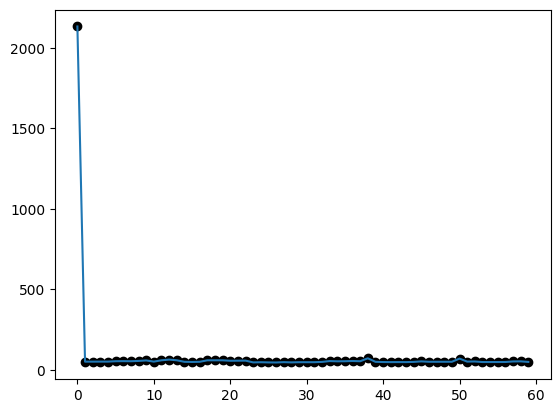

In [32]:
plt.plot(erro_lis)
plt.scatter(range(len(erro_lis)),erro_lis,color="black")
plt.show

In [33]:
erro_lis

[2132.2679701943453,
 50.11176047770353,
 50.21643154044321,
 50.40417397818995,
 50.35015212790404,
 52.77717229319297,
 53.339786259833254,
 52.77300384535676,
 54.6535520150237,
 57.637015911952,
 50.36901862486966,
 58.55261598670235,
 62.9353344477253,
 58.55064570721152,
 49.21269750627152,
 48.25267735420372,
 49.248901141536344,
 58.46752075905701,
 58.46659941790183,
 58.46555351837043,
 55.70787106246358,
 56.09403336974703,
 56.53590602426145,
 45.453328178036024,
 46.62444849592061,
 45.45350191291015,
 44.99087771454816,
 47.03152958733024,
 45.59879794898916,
 46.69516549802336,
 46.73632016978375,
 46.69457008208294,
 48.59899973472045,
 53.787991437510804,
 52.279578667227625,
 52.73187661035155,
 54.24479980837784,
 52.73058081340683,
 70.91133373609689,
 49.124230399194225,
 47.64864286001838,
 47.22752660309427,
 47.425594913182024,
 47.22774295690344,
 48.618931922243526,
 51.82074268079519,
 49.44366872535014,
 49.41792401495673,
 49.42287964775364,
 49.41759681989

In [34]:
#S_Jを更新
X_y=np.row_stack((X_1,X_2,y))
U_theta_1=np.row_stack((U_1,U_2,theta_1)) #1
W_1_S_1=W_1.dot(S_1) 
W_2_S_2=W_2.dot(S_2)
theta_2i_S_i=theta_21.dot(S_1)+theta_22.dot(S_2) 
W_theta_2i_S_i=np.row_stack((W_1_S_1,W_2_S_2,theta_2i_S_i)) #2
X_y_joint=X_y-W_theta_2i_S_i #1,2からjoint空間を算出
U_J,sigma_J,VT_J=np.linalg.svd(X_y_joint,full_matrices=False) #特異値分解を行う
S_J=VT_J[:r_J,:]

In [35]:
#U_1,U_2,theta_1を更新
##U_1,U_2を更新
X=np.row_stack((X_1,X_2)) #2
W_1_S_1=W_1.dot(S_1)
W_2_S_2=W_2.dot(S_2)
W_S=np.row_stack((W_1_S_1,W_2_S_2)) #3
U=(X-W_S).dot(S_J.T) #1,2,3からU_theta_1を更新
U_1=U[:p_1,:]
U_2=U[p_1:p_1+p_2,:]

##theta_1を更新
pcLasso_sigma_J=[]
for i in range(len(sigma_J)):
    a_i=sigma_J[0]**2-sigma_J[i]**2
    pcLasso_sigma_J.append(a_i)
sigma_J_final=[1/(sigma_J[i]**2+(gamma_1/2)*pcLasso_sigma_J[i]) for i in range(len(sigma_J))]
diag_sigma_J_final=np.diag(sigma_J_final)
diag_sigma_J_final_r_J=diag_sigma_J_final[:r_J,:r_J]
theta_1=(y-(theta_21.dot(S_1)+theta_22.dot(S_2))).dot(S_J.T).dot(diag_sigma_J_final_r_J)


In [36]:
theta_1

array([[ 3.45903385e-04, -8.13987006e-04, -5.01161145e-04,
        -1.58803566e-04, -1.19560516e-05, -2.20241596e-04,
        -1.66677471e-05,  4.47172826e-05, -1.79504112e-04,
         2.02786960e-06]])

In [37]:
diag_sigma_J_final_r_J

array([[4.67925808e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.64438196e-04, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.41304592e-04, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.12089321e-04,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.01950982e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
   

In [38]:
sigma_J

array([4.62286808e+01, 3.39269159e+01, 3.00355780e+01, 2.09999889e+01,
       1.48055677e+01, 1.19609933e+01, 6.32017254e+00, 3.27100957e+00,
       2.02355572e+00, 2.96839583e-01, 1.30177438e-02, 4.56614531e-03,
       8.17020522e-04, 5.06815248e-14, 4.10593167e-14, 9.57137874e-15,
       9.34473571e-15, 8.95415328e-15, 8.20297383e-15, 7.96147432e-15,
       7.51201869e-15, 7.30391584e-15, 7.17408787e-15, 6.97442858e-15,
       6.82148583e-15, 6.65576112e-15, 6.58167458e-15, 6.54346057e-15,
       6.27513737e-15, 6.19244671e-15, 6.11547690e-15, 5.33342065e-15,
       4.82136918e-15, 4.62861884e-15, 4.61647197e-15, 4.46515522e-15,
       3.97499187e-15, 3.53890055e-15, 3.53890055e-15, 3.53890055e-15,
       3.53890055e-15, 3.53890055e-15, 3.53890055e-15, 3.53890055e-15,
       3.53890055e-15, 3.53890055e-15, 3.53890055e-15, 3.53890055e-15,
       3.53890055e-15, 3.53890055e-15, 3.53890055e-15, 3.53890055e-15,
       3.53890055e-15, 3.53890055e-15, 3.53890055e-15, 3.53890055e-15,
      

In [39]:
pcLasso_sigma_J

[0.0,
 986.0553084499174,
 1234.9549791464667,
 1696.0913927958077,
 1917.8860925245474,
 1994.0255658761093,
 2097.1463468733655,
 2126.391424190308,
 2132.9961500245413,
 2137.0028140477975,
 2137.090758324094,
 2137.090906936064,
 2137.0909271182245,
 2137.090927785747,
 2137.090927785747,
 2137.090927785747,
 2137.090927785747,
 2137.090927785747,
 2137.090927785747,
 2137.090927785747,
 2137.090927785747,
 2137.090927785747,
 2137.090927785747,
 2137.090927785747,
 2137.090927785747,
 2137.090927785747,
 2137.090927785747,
 2137.090927785747,
 2137.090927785747,
 2137.090927785747,
 2137.090927785747,
 2137.090927785747,
 2137.090927785747,
 2137.090927785747,
 2137.090927785747,
 2137.090927785747,
 2137.090927785747,
 2137.090927785747,
 2137.090927785747,
 2137.090927785747,
 2137.090927785747,
 2137.090927785747,
 2137.090927785747,
 2137.090927785747,
 2137.090927785747,
 2137.090927785747,
 2137.090927785747,
 2137.090927785747,
 2137.090927785747,
 2137.090927785747,
 2137.

<function matplotlib.pyplot.show(close=None, block=None)>

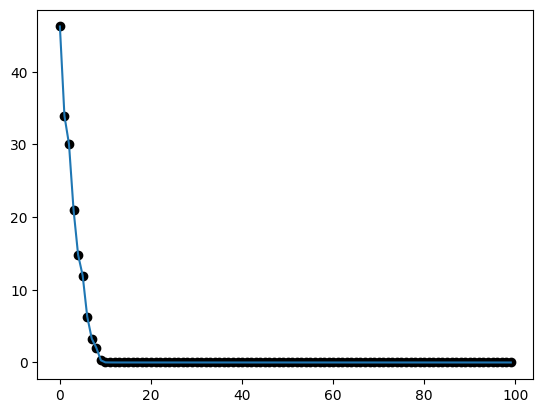

In [43]:
plt.plot(sigma_J)
plt.scatter(range(len(sigma_J)),sigma_J,color="black")
plt.show

In [58]:
x=np.random.uniform(low=-0.1, high=0.1, size=(100,100))

In [56]:
L,Lam,M=np.linalg.svd(x)

In [59]:
L_1=L[:99,:10]
L_1.shape

(99, 10)

In [60]:
L=L[:,:10]
L.shape

(100, 10)

In [61]:
L.T.dot(L)

array([[ 1.00000000e+00,  3.04087120e-16,  3.32502210e-17,
        -5.05353733e-16, -2.78194923e-16, -3.89481992e-16,
         4.65681915e-16, -9.33531332e-17, -9.03900441e-17,
        -3.04341733e-17],
       [ 3.04087120e-16,  1.00000000e+00, -5.32441243e-16,
        -8.43748568e-16,  3.25685116e-16,  4.52438117e-17,
         9.41925141e-17, -1.18464415e-16,  3.06176788e-16,
        -6.45140593e-16],
       [ 3.32502210e-17, -5.32441243e-16,  1.00000000e+00,
        -1.53934847e-16, -4.39878495e-17, -3.61618813e-16,
        -2.08904553e-16, -3.76149787e-16,  6.60849786e-17,
         1.68187837e-17],
       [-5.05353733e-16, -8.43748568e-16, -1.53934847e-16,
         1.00000000e+00,  6.58772205e-16,  1.80021412e-16,
        -1.11444901e-16, -2.94356124e-16, -3.79200470e-16,
        -3.35865743e-16],
       [-2.78194923e-16,  3.25685116e-16, -4.39878495e-17,
         6.58772205e-16,  1.00000000e+00,  1.81686658e-17,
        -1.44678855e-17, -2.25283645e-16, -1.08308910e-16,
         1.

In [62]:
L_1.T.dot(L_1)

array([[ 9.86530337e-01, -2.96424617e-03, -1.38276797e-02,
        -1.99697209e-02,  2.28439122e-04,  1.18539699e-02,
         5.43788791e-03, -8.53062816e-04, -1.11929284e-02,
        -1.71453707e-03],
       [-2.96424617e-03,  9.99347663e-01, -3.04303424e-03,
        -4.39470294e-03,  5.02722140e-05,  2.60868326e-03,
         1.19670686e-03, -1.87732101e-04, -2.46320895e-03,
        -3.77315292e-04],
       [-1.38276797e-02, -3.04303424e-03,  9.85804788e-01,
        -2.05005053e-02,  2.34510911e-04,  1.21690421e-02,
         5.58242404e-03, -8.75736765e-04, -1.14904304e-02,
        -1.76010853e-03],
       [-1.99697209e-02, -4.39470294e-03, -2.05005053e-02,
         9.70393488e-01,  3.38677027e-04,  1.75743422e-02,
         8.06205037e-03, -1.26472548e-03, -1.65943017e-02,
        -2.54192150e-03],
       [ 2.28439122e-04,  5.02722140e-05,  2.34510911e-04,
         3.38677027e-04,  9.99996126e-01, -2.01037727e-04,
        -9.22240087e-05,  1.44675421e-05,  1.89826775e-04,
         2.

In [ ]:
L_1.T.dot(L_1)

array([[ 9.86530337e-01, -2.96424617e-03, -1.38276797e-02,
        -1.99697209e-02,  2.28439122e-04,  1.18539699e-02,
         5.43788791e-03, -8.53062816e-04, -1.11929284e-02,
        -1.71453707e-03],
       [-2.96424617e-03,  9.99347663e-01, -3.04303424e-03,
        -4.39470294e-03,  5.02722140e-05,  2.60868326e-03,
         1.19670686e-03, -1.87732101e-04, -2.46320895e-03,
        -3.77315292e-04],
       [-1.38276797e-02, -3.04303424e-03,  9.85804788e-01,
        -2.05005053e-02,  2.34510911e-04,  1.21690421e-02,
         5.58242404e-03, -8.75736765e-04, -1.14904304e-02,
        -1.76010853e-03],
       [-1.99697209e-02, -4.39470294e-03, -2.05005053e-02,
         9.70393488e-01,  3.38677027e-04,  1.75743422e-02,
         8.06205037e-03, -1.26472548e-03, -1.65943017e-02,
        -2.54192150e-03],
       [ 2.28439122e-04,  5.02722140e-05,  2.34510911e-04,
         3.38677027e-04,  9.99996126e-01, -2.01037727e-04,
        -9.22240087e-05,  1.44675421e-05,  1.89826775e-04,
         2.